In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sys.path.append("C:/Users/jakob/Documents/MLandData/OtherFiles")
import Alexandria as lib
alpha = 0.9
beta = 0.2
gamma = 0.1

lambdas = [1,5]


n = 10
T = 100

Gamma = np.array([1-gamma,0,gamma,0,1-gamma,gamma,beta/2,beta/2,1-beta]).reshape((3,3))


def PZ1(c):
    if c == 0:
        return 1 - alpha
    if c == 1:
        return alpha
    if c == 2:
        return 0.5


In [139]:
def simulate(n,T,C0 = 0):
    C = np.empty(T,dtype = int)
    z = np.empty((T,n),dtype = int)
    x = np.empty((T,n))

    for t in range(T):

        C[t] = np.random.choice([0,1,2],p = Gamma[C[t-1],:]) if t > 0 else C0

        z[t] = np.random.random(n) < PZ1(C[t])

        x[t] = np.random.poisson([lambdas[k] for k in  z[t]]) 

        
    return (C,z,x)

Plot generated data

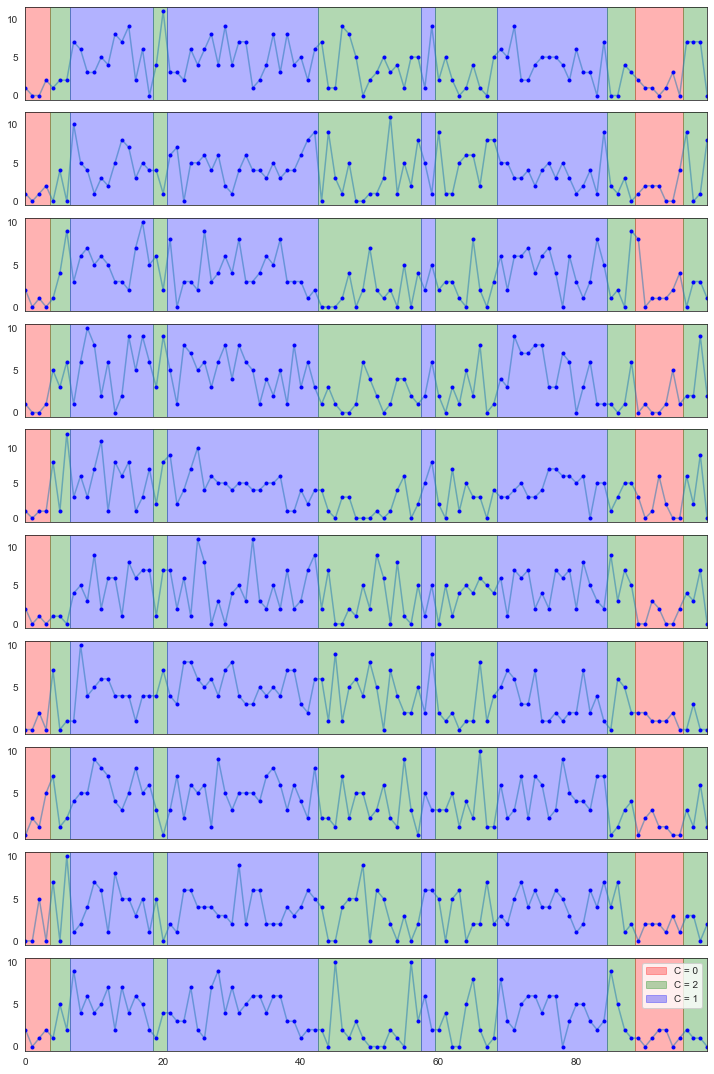

In [140]:
sns.set_style("white")

C, z, x = simulate(n,T,0)


fig, axs = plt.subplots(n,1,figsize = (10,15),sharex=True)

x_split = [x[C == i] for i in range(3)]
x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

for nn in range(n):
    axs[nn].plot(x[:,nn],alpha = 0.5)
    axs[nn].plot(x[:,nn],'.',color= "blue")
    cc = C[0]
    lt = 0
    made = np.zeros(3).astype(bool)
    for t in range(1,T):
        if cc != C[t]:
            if not made[cc]:
                made[cc] = True
                axs[nn].axvspan(lt-0.5, t-0.5, alpha=0.3, color=['red','blue','green'][cc],label = f"C = {cc}")
            else:
                axs[nn].axvspan(lt-0.5, t-0.5, alpha=0.3, color=['red','blue','green'][cc])
            cc = C[t]
            lt = t
    axs[nn].axvspan(lt-0.5,T-0.5, alpha=0.3, color=['blue','red','green'][cc])

    axs[nn].set_xlim(0,T-1)
    axs[nn].set_yticks([0,5,10])

plt.legend()
plt.tight_layout(pad = 1)
plt.show()

In [143]:
C, z, X = simulate(30,2*2*50000,0)


clf = LogisticRegression().fit(X,C)




In [145]:
C, z, x = simulate(30,T,0)

C_pred = clf.predict(x)


fig, axs = plt.subplots(n,1,figsize = (10,15),sharex=True)

x_split = [x[C == i] for i in range(3)]
x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

p = 0.2

for nn in range(6):
    axs[nn].plot(x[:,nn],alpha = 0.5)
    axs[nn].plot(x[:,nn],'.',color= "blue")
    cc = C[0]
    cc_pred = C_pred[0]
    lt = 0
    lt_pred = 0
    for t in range(1,T):
        if cc != C[t]:
            axs[nn].axvspan(lt-0.5, t-0.5, ymin = 0, ymax = p,alpha=0.3, color=['red','blue','green'][cc])
            cc = C[t]
            lt = t

        if cc_pred != C_pred[t]:
            axs[nn].axvspan(lt_pred-0.5, t-0.5, ymin = p, ymax = 1,alpha=0.3, color=['red','blue','green'][cc_pred])
            cc_pred = C_pred[t]
            lt_pred = t

    axs[nn].axvspan(lt-0.5,T-0.5, ymin = 0, ymax = p, alpha=0.3, color=['blue','red','green'][cc])
    axs[nn].axvspan(lt_pred-0.5,T-0.5, ymin = p, ymax = 1, alpha=0.3, color=['blue','red','green'][cc_pred])

    axs[nn].set_xlim(0,T-1)
    axs[nn].set_yticks([0,5,10])

plt.legend()
plt.tight_layout(pad = 1)
plt.show()

ValueError: X has 30 features per sample; expecting 10